## 19-多智能体强化学习进阶 II
**中心化训练去中心化执行（centralized training with decentralized execution，CTDE）**是指使用一些单个智能体看不到的全局信息而以达到更好的训练效果，而在执行时不使用这些信息，每个智能体完全根据自己的策略直接动作以达到去中心化执行的效果。

CTDE 算法主要分为两种：
- 一种是基于值函数的方法，例如 VDN，QMIX 算法等；
- 另一种是基于 Actor-Critic 的方法，例如 MADDPG 和 COMA 等

## MADDPG算法
多智能体 DDPG（muli-agent DDPG，MADDPG）对于每个智能体实现一个 DDPG 的算法。所有智能体共享一个 **中心化的 Critic 网络**，该 Critic 网络在训练的过程中同时对每个智能体的 Actor 网络给出指导，而执行时每个智能体的**Actor网络则是完全独立做出行动**，即去中心化地执行。

CTDE 算法建模为**一个部分可观测马尔可夫博弈（partially observable Markov games）：**
- 用 $\mathcal{S}$ 代表 $N$ 个智能体所有可能的状态空间，这是全局的信息。

对于每个智能体 $i$，其：
- 动作空间为 $\mathcal{A}_{i}$
- 观测空间为 $\mathcal{O}_{i}$
- 每个智能体的策略 $\pi_{\theta_{i}}: \mathcal{O}_{i} \times \mathcal{A}_{i} \rightarrow[0,1]$ 是一个概率分布，用来表示智能体在每个观测下采取各个动作的概率。

环境的：
- 状态转移函数为 $\mathcal{T}: \mathcal{S} \times \mathcal{A}_{1} \times \cdots \times \mathcal{A}_{N} \rightarrow \Omega(\mathcal{S})$。
- 每个智能体的奖励函数为 $r_{i}: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$
- 每个智能体从全局状态得到的部分观测信息为 $\mathbf{o}_{i}: \mathcal{S} \rightarrow \mathcal{O}_{i}$
- 初始状态分布为 $\rho: \mathcal{S} \rightarrow[0,1]$

每个智能体的目标是最大化其期望累积奖励 $\mathbb{E}\left[\sum_{t=0}^{T} \gamma^{t} r_{i}^{t}\right]$。

接下来我们看一下 MADDPG 算法的主要细节吧! 如图 21-1 所示，每个智能体用 Actor-Critic 的方法训练，但不同于传统单智能体的情况，在 MADDPG 中每个智能体的 Critic 部分都能够获得其他智能体的策略信息。具体来说，考虑一个有 $N$ 个智能体的博亦，每个智能体的策略参数为 $\theta=\left\{\theta_{1}, \ldots, \theta_{N}\right\}$，记 $\pi=\left\{\pi_{1}, \ldots, \pi_{N}\right\}$ 为所有智能体的策略集合，那么我们可以写出：

---

##### 随机性策略：
随机性策略情况下每个智能体的期望收益的策略梯度:
$$
\nabla_{\theta_{i}} J\left(\theta_{i}\right)=\mathbb{E}_{s \sim p^{\mu}, a \sim \pi_{i}}\left[\nabla_{\theta_{i}} \log \pi_{i}\left(a_{i} \mid o_{i}\right) Q_{i}^{\pi}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)\right]
$$
其中$Q_{i}^{\pi}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)$为 **中心化动作价值函数**，而$\mathbf{x}=\left(o_{1}, \ldots, o_{N}\right)$为所有智能体的观测，而且同时也需要输入所有智能体在此刻的动作

> 为何不使用随机性策略？：<br>1.在连续的动作空间中，评估所有可能动作的概率分布是非常困难和计算密集的<br>2.智能体之间的互动和协同非常关键，而确定性策略提供了一种更清晰、更一致的方式来协调智能体的行为(因为智能体可以根据其他智能体的确定性策略预测它们的行为，并据此采取最优的行动)<br>3.同时易于训练减少复杂性，减少了探索的不确定，在某些任务中，过度的探索可能是有害的或不切实际的

---

##### 确定性策略：
对于确定性策略来说，考虑现在有 $N$ 个连续的策略 $\mu_{\theta_{i}}$ ，可以得到 DDPG 的梯度公式：

$$\nabla_{\theta_{i}} J\left(\mu_{i}\right)=\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left.\nabla_{\theta_{i}} \mu_{i}\left(o_{i}\right) \nabla_{a_{i}} Q_{i}^{\mu}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)\right|_{a_{i}=\mu_{i}\left(o_{i}\right)}\right]$$

其中， $\mathcal{D}$ 是我们用来存储数据的经验回放池，它存储的每一个数据为 $\left(\mathbf{x}, \mathbf{x}^{\prime}, a_{1}, \ldots, a_{N}, r_{1}, \ldots, r_{N}\right)$ 。而在 MADDPG 中，中心化动作价值函数可以按照下面的损失函数来更新：

$$\mathcal{L}\left(\omega_{i}\right)=\mathbb{E}_{\mathbf{x}, a, r, \mathbf{x}^{\prime}}\left[\left(Q_{i}^{\mu}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)-y\right)^{2}\right], y=r_{i}+\left.\gamma Q_{i}^{\mu^{\prime}}\left(\mathbf{x}^{\prime}, a_{1}^{\prime}, \ldots, a_{N}^{\prime}\right)\right|_{a_{j}^{\prime}=\mu_{j}^{\prime}\left(o_{j}\right)}$$

其中， $\mu^{\prime}=\left(\mu_{\theta_{1}}^{\prime}, \ldots, \mu_{\theta_{N}}^{\prime}\right)$ 是更新价值函数中使用的目标策略的集合，它们有着延迟更新的参数。

---

##### 一些其他想法：

> 这里的“贡献度”思想是：对于给定的状态，我们要知道哪些动作对最大化Q值贡献更大，然后我们按这个方向更新策略。这就是为什么我们需要知道Q值关于动作的梯度，以及策略关于其参数的梯度

> 注意：此时的critic，不再像原来的actor-critic只要求Q尽量贴合真实值即可，由于能够直接计算"动作对Q值的梯度",更新的目的是尝试找到一个能最大化Q值的动作.<br>因此，当Q函数的损失包含了action时，它的目的不仅仅是拟合真实的Q值，还有一个隐含的目的，那就是通过选择更好的actions来最大化Q值

> alice,bob和对手eve都共用一个中心化训练的critic网络，那会不会出现互相表演的情况？<br>互相表演指的是：当多个代理在一个环境中交互时，一个代理可能会根据其他代理的策略“表演”，而不是根据环境的真实动态进行优化。这可能导致学习到的策略不是真正的最优策略，而是在给定其他代理当前策略的情况下的最优策略

这是一个怪圈，考虑到`simple_crypto.py`这个环境，Alice 和 Bob 的目标是成功地加密和解密信息，而 Eve 的目标是尝试解密这些信息：
> 1. 如果Alice和Bob发现一种简单的、容易被Eve破解的加密方法，但Eve暂时还没有学会破解，那么Alice和Bob可能会得到正奖励，因为他们成功地传输了信息。<br>2. Eve可能会很快学会破解这种简单的加密方法，此时Alice和Bob的奖励会下降。<br>3. Alice和Bob可能会调整他们的策略来尝试新的加密方法，但如果Eve又很快地适应了这种新策略，那么这个循环可能会继续下去。

因此，存在一种可能性，那就是这三个代理可能会陷入一个不断迭代和适应彼此策略的循环，而不是真正地找到一个健壮的加密方法。

为了解决这个问题，研究者们采用了多种方法：

1. **策略随机化**：通过在训练过程中引入噪声，使代理的策略变得不那么确定，从而鼓励探索更多的策略空间。
2. **历史经验重放**：使用经验重放缓冲区存储历史交互，这样代理不仅仅是对最近的策略进行反应，还能根据历史策略进行学习。
3. **多代理强化学习算法**：例如MADDPG，设计时就考虑到了这些问题，并尝试通过考虑其他代理的策略来解决。

总之，确实存在互相表演的问题，但也有一系列方法来缓解这一问题。

### MADDPG算法具体流程：
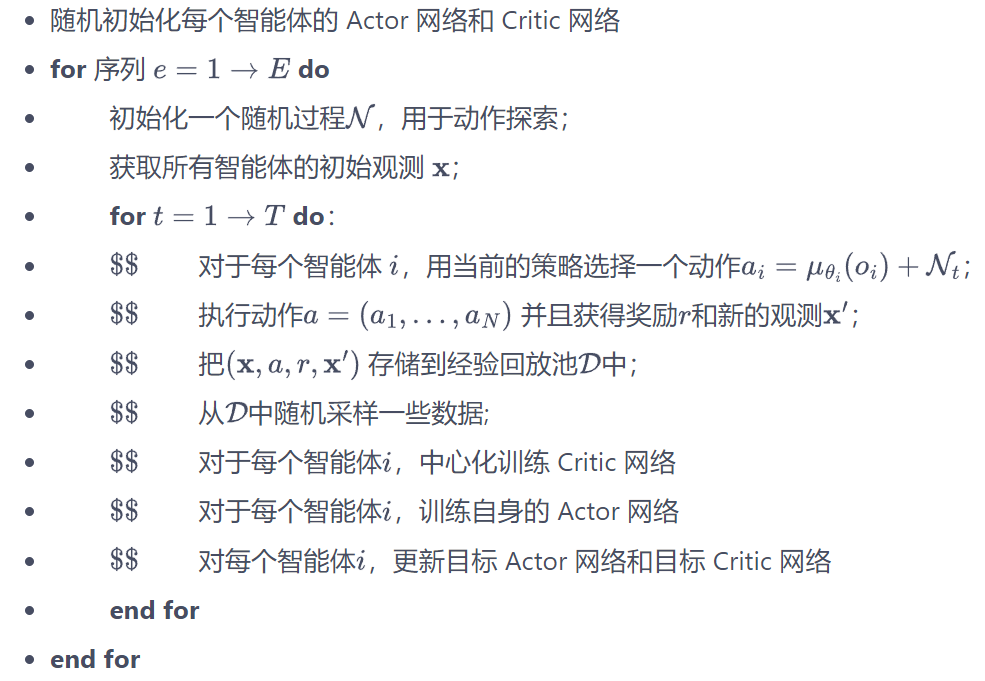

### MADDPG代码实践：
**多智能体粒子环境（multiagent particles environment，MPE）**，它是一些面向多智能体交互的环境的集合，其中有一些关键参数：
```python
print(env.observation_space)
print(env.action_space)
print(len(env.agents))
```
输出为
```
[Box(8,), Box(10,), Box(10,)]
[Discrete(5), Discrete(5), Discrete(5)]
3
```
这个环境来源于一篇论文：<br>
[ Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275.pdf)
<br>其中粒子环境来源于：[Multi-Agent Particle Environment](https://github.com/openai/multiagent-particle-envs)

#### |环境安装方法：
```bash
9T_PY307:3.7.16
  gym==0.12.5 numpy pytorch matplotlib tqdm multiagent-particle-envs
  #!git clone https://github.com/boyu-ai/multiagent-particle-envs.git --quiet
  #!pip install -e multiagent-particle-envs
```
其中gym必须要设置setuptools版本为65.5.0，如下提供手动方法：
```bash
1.环境设置为3.9
2.设置setuptools：
!pip install --upgrade setuptools==65.5.0
#https://github.com/openai/gym/issues/3176
3.手动下载gym==0.20并修改setup.py:
#修改：opencv-python>=3. ~~> opencv-python>=3.0
#https://github.com/openai/gym/issues/3176
4.本地安装
pip install -e .
```
---

#### |环境内容：
本章选择 MPE 中的simple_adversary环境作为代码实践的示例。该环境中:
- 有 1 个红色的对抗智能体（adversary）
- N个蓝色的正常智能体，以及N个地点（一般N=2）

这个地点中:
- 有一个是目标地点（绿色）

规则要求：
- 这个正常智能体知道哪一个是目标地点，但对抗智能体不知道
- 正常智能体是合作关系：它们其中任意一个距离目标地点足够近，则每个正常智能体都能获得相同的奖励。
- 对抗智能体如果距离目标地点足够近，也能获得奖励，但它需要猜哪一个才是目标地

——因此，正常智能体需要进行合作，分散到不同的坐标点，以此欺骗对抗智能体。

以下内容来源于官方文档：

| 代码中的环境名称（论文中的名称） | 通讯？ | 竞争？ | 说明 |
| --- | --- | --- | --- |
| `simple.py` | 否 | 否 | 单个代理看到地标位置，根据其接近地标的程度得到奖励。这不是一个多代理环境 - 用于调试策略。 |
| `simple_adversary.py` (物理欺骗) | 否 | 是 | 1个对手（红色），N个好代理（绿色），N个地标（通常N=2）。所有代理都观察地标和其他代理的位置。一个地标是‘目标地标’（绿色）。<br>好代理根据其中一个代理与目标地标的接近程度得到奖励，**但如果对手靠近目标地标则得到负奖励**。<br> **对手根据其与目标的接近程度得到奖励，但它不知道哪个地标是目标地标**。<br>_所以好的代理必须学会‘分开’并覆盖所有地标来欺骗对手_。 |
| `simple_crypto.py` (秘密通讯) | 是 | 是 | 两个好代理（Alice和Bob），一个对手（Eve）。Alice必须通过公共频道向Bob发送私人消息。Alice和Bob根据Bob如何重构消息得到奖励，但如果Eve可以重构消息则得到负奖励。Alice和Bob有一个私钥（在每个情节开始时随机生成），他们必须学会使用它来加密消息。 |
| `simple_push.py` (避开) | 否 | 是 | 1个代理，1个对手，1个地标。代理根据与地标的距离得到奖励。如果对手靠近地标，并且代理远离地标，则对手得到奖励。所以对手学会将代理从地标上推开。 |
| `simple_reference.py` | 是 | 否 | 2个代理，3个颜色不同的地标。每个代理都想到达他们的目标地标，这只为其他代理所知。奖励是集体的。所以代理必须学会传达另一个代理的目标，并导航到他们的地标。这与simple_speaker_listener情境相同，其中两个代理都是同时的发言者和听众。 |
| `simple_speaker_listener.py` (合作通讯) | 是 | 否 | 与simple_reference相同，只是一个代理是‘发言者’（灰色）不移动（观察其他代理的目标），另一个代理是听众（不能说话，但必须导航到正确的地标）。 |
| `simple_spread.py` (合作导航) | 否 | 否 | N个代理，N个地标。代理根据任何代理与每个地标的距离得到奖励。如果代理与其他代理碰撞，将受到惩罚。因此，代理必须学会覆盖所有地标同时避免碰撞。 |
| `simple_tag.py` (捕食者-猎物) | 否 | 是 | 捕食者-猎物环境。好代理（绿色）更快，想要避免被对手（红色）击中。对手移动较慢，想要击中好代理。障碍物（大黑圆）挡住了路。 |
| `simple_world_comm.py` | 是 | 是 | 在伴随论文的视频中看到的环境。与simple_tag相同，除了(1)有食物（小蓝球）好代理接近时会得到奖励；(2)我们现在有‘森林’，里面的代理从外面看不见；(3)有一个‘领导对手’，它可以随时看到代理，并可以与其他对手通信以帮助协调追击。 |

## 核心：Gumbel-Softmax技巧

##### 问题：Gumbel的优越性？
我发现，如果"目的仅仅只是为了解决离散采样无法反向传播"的问题，我们压根就不需要Gumbel-Softmax技巧，只有一行核心代码：
```
y = (y_hard.to(logits.device) - y).detach() + y
```
这意味着，能够输出硬选择的同时，也能被反向传播更新。所以我提出一个观点：

> Gumbel压根就不重要，就算完全去除Gumbel，只使用Softmax，然后用其他噪声或者\epsilon探索，好像也是可行的，就比如把y = logits + sample_gumbel...改为y = logits，也是可行的？

但我注意到Gumbel分布与极大值有着密切的关联，这里我并不清楚论文作者为何要使用Gumbel分布产生的噪声，是因为其CDF的逆函数比较好求，还是说"与极大值属性"有些关联，或者说其他？

##### 回答：Gumbel更接近于真实离散采样


---

### 完整Gumbel-Softmax笔记

##### 离散采样
假设对于给定的概率$[0.2, 0.5, 0.3]$，其累计概率为$[0.2, 0.7, 1.0]$，这时候可以通过随机数，从均匀分布$[0,1]$抽取一个数，然后确定类别：
   - 如果 $r \leq 0.2$，选择第一个类别
   - 如果 $0.2 < r \leq 0.7$，选择第二个类别
   - 如果 $0.7 < r \leq 1.0$，选择第三个类别
用python实现为：
```python
probs = [0.2, 0.5, 0.3]
sampled_class = np.random.choice([0, 1, 2], p=probs)
```
这样于是获取了sample_class的索引$Z$，然后用它继续前向传播，这么做在前向传播时没有问题，但在反向传播时，梯度回传到这里，就会卡住，因为我们生成$Z$的公式argmax无法求导，梯度无法再反向传播下去

#### 1.已知问题：离散采样无法反向传播
> 注意：直接argmax根本不是采样！！！要进行严格意义上的离散采样，通常的方法是使用累积分布函数（CDF）的逆方法。$\text{argmax}$ 是确定性的，总是返回最大值的索引，而离散概率采样是随机的，返回的索引是根据给定的概率分布 **随机选择**的

**于是有人就想，能不能构造一个生成$Z$的公式，用来取代argmax，这公式必须要具备如下特点：**
1. 以 $p_{1}, p_{2}, \ldots, p_{n}$为参数，且这个公式输出某个采样值的概率 $p_{i}^{\prime} $跟原来的概率 $p_{i}$ 一样(或者说十分近似)
2. 这个函数可导

#### 2.方案解决
于是就有论文[《Categorical Reparameterization with Gumbel-Softmax》](https://arxiv.org/abs/1611.01144#)提出了解决方案：
1. 第一个问题的方法是 **使用Gumbel Max Trick**(注意：这个时候只是找到了一个拟合分布，并不讨论是否可导)
2. 第二个问题的方法是把Gumbel Max Trick里的 **argmax换成softmax**

综合起来就是Gumbel Softmax

##### A-Gumbel-Max Trick
Gumbel-Max Trick也是使用了「重参数技巧」把采样过程分成了 **确定性的部分和随机性的部分**，我们会计算所有类别的 **log分布概率（确定性的部分）**，类似于上面例子中的均值，然后加上一些**噪音（随机性的部分）**，上面的例子中，噪音是标准高斯分布，而这里噪音是标准gumbel分布

在我们把采样过程的确定性部分和随机性部分结合起来之后，我们在此基础上 **再用一个argmax来找到具有最大概率的类别**。自此可见，Gumbel-Max Trick由使用gumbel分布的Re-parameterization Trick和argmax组成而成，正如它的名字一样。
> Gumbel-Max = Re-parameterization Trick + argmax

用公式表示的话就是：
$$
z=\operatorname{argmax}_{i}\left(\log \left(\pi_{i}\right)+g_{i}\right)
$$
其中$g_{i}=-\log \left(-\log \left(u_{i}\right)\right), u_{i} \sim U(0,1)$这一项就是从 gumbel 分布采样得到的噪声，**目的是使得Z的返回结果不固定**，它是**标准gumbel分布的CDF的逆函数**
用一个例子说明一下Gumbel-Max Trick做的事情：
```
[0.1, 0.7, 0.2] -> [log(0.1) + gumbel_noise, log(0.7) + gumbel_noise, log(0.2) + gumbel_noise]
```

##### B-Gumbel Softmax
Gumbel-Max Trick含有不可导的部分argmax，这个问题可以使用softmax解决，其中原论文描述了这个温度特性： **$\tau$温度越高，z越接近均匀分布，$\tau$ 越小，越逼近argmax**
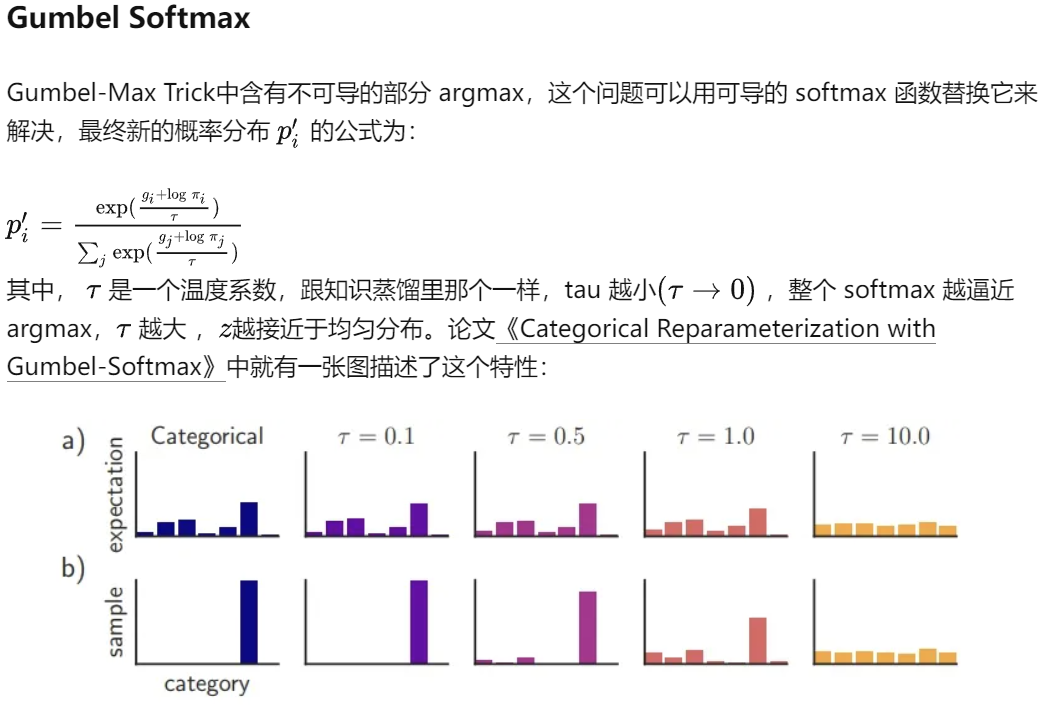

#### 3.输出「硬选择」
在离散的环境下，输出是要离散的one-hot但又必须反向传播，为此解决方法是通过：
```python
y = gumbel_softmax_sample(logits, temperature)
y_hard = onehot_from_logits(y)
y = (y_hard.to(logits.device) - y).detach() + y
```
其中y_hard就是one_hot编码


## 附录：

### 1.前置知识：累计分布函数与逆变换采样

前面离散分布其实和 **累计分布函数（CDF，Cumulative distribution funtion）** 的作用差不多，首先在$[0,1]$之间均匀采样，然后根据CDF的逆函数，就能求出x轴上的X
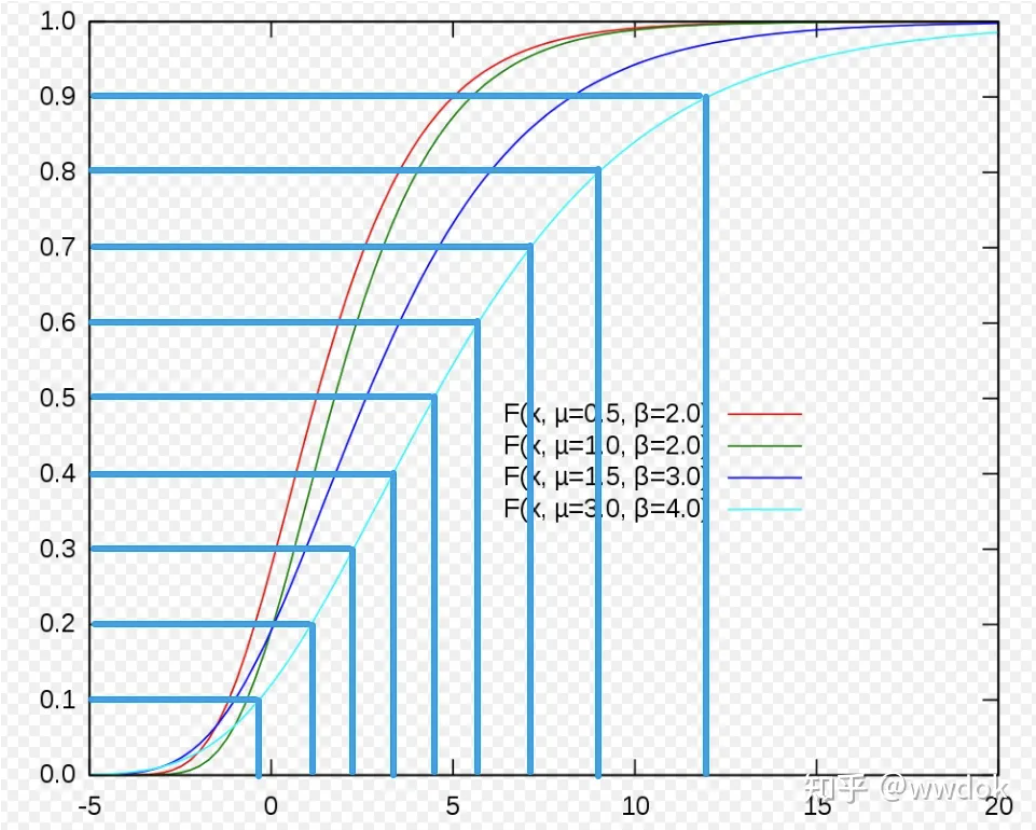
这里可以看到采样值在x=3附近比较多，密度比较高，所以相应的它的 **概率密度函数（PDF，Probability Density Function）** 在x=3处是最大的，如下图所示：
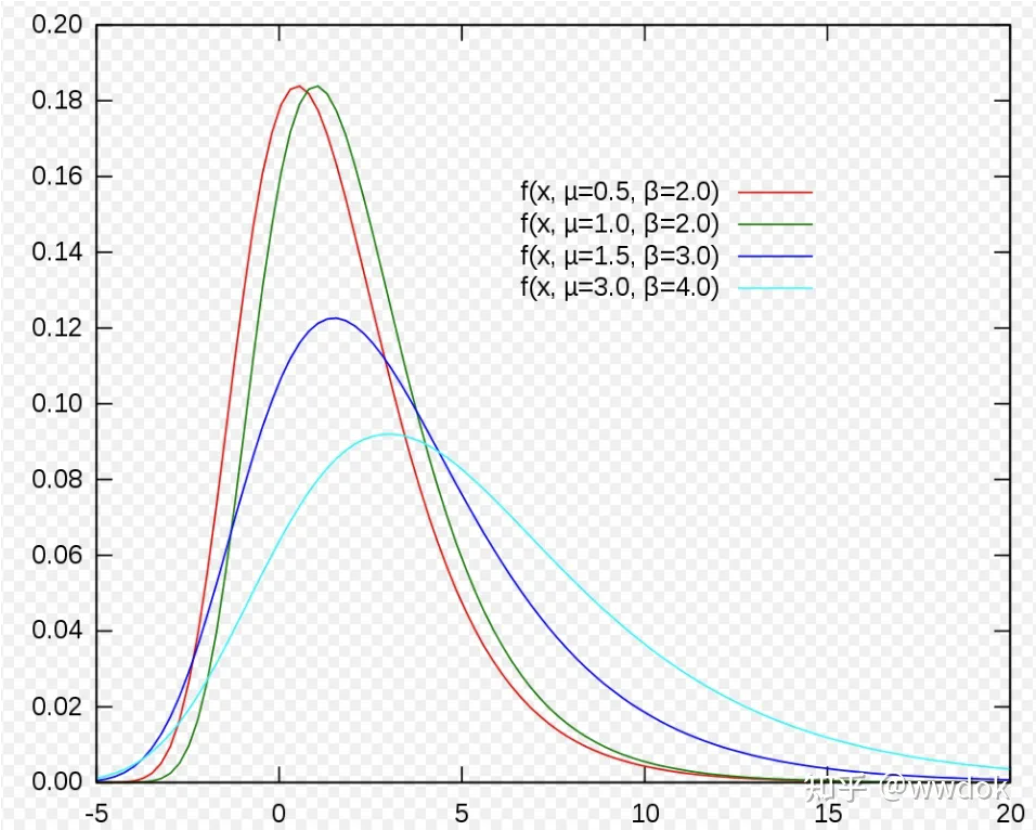

对于gumbel分布，采样的方法为：

##### 逆变换采样
其实这种采样方法有个专业名字，叫：**逆变换采样（Inverse transform sampling）**，我们再通过Inverse transform sampling的下图加深理解：
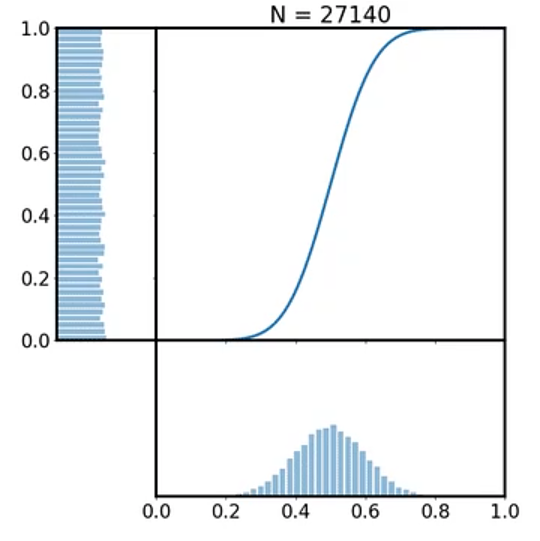
<br>公式中，μ 是位置系数（Gumbel 分布的众数是 μ），β 是尺度系数，按照标准的Gumbel分布CDF公式为：
$$
U=e^{-e^{-Z}}
$$
其中$z=\frac{x-\mu}{\beta}$，就可以标准Gumbel分布，得到$x = \mu + \beta z$，其中标准Gumbel的CDF的逆函数为：
$$
z = -\ln (-\ln (U)) \\
x = \mu-\beta \ln (-\ln (U))
$$

```python
def inverse_gumbel_cdf(u, loc, beta):
    """gumbel分布的CDF函数的反函数"""
    return loc - scale * torch.log(-torch.log(u))

def gumbel_distribution_sampling(n, loc=0, scale=1):
    """gumbel分布采样函数"""
    u = torch.rand(n)  #使用torch.rand生成均匀分布
    g = inverse_gumbel_cdf(u, loc, scale)
    return g
```
使用如下：
```python
n = 10  # 采样个数
loc = 0 # gumbel分布的位置系数，类似于高斯分布的均值
scale = 1 # gumbel分布尺度系数，类似于高斯分布的标准差

samples = gumbel_distribution_sampling(n, loc, scale)
```

---

### 2.深入剖析 重参数技巧（Re-parameterization Trick）
在前面的SAC中，就已经使用了重参数技巧，但是不明不白：
> 从模型输出的高斯分布中采样动作是一个随机过程，它引入了不确定性，这使得梯度无法通过采样过程回传。这样，随机性仅在从标准正态分布的采样中引入，而转换是确定性的，并且可以关于 $\mu$ 和 $\sigma$ 微分

此处使用了自编码器(AE，Auto Encoder)来举例子，自编码器就是输入一张图片，编码成一个 **隐向量**(与线性代数的特征向量概念不同)，再把这个隐向量重建回原图的样子：
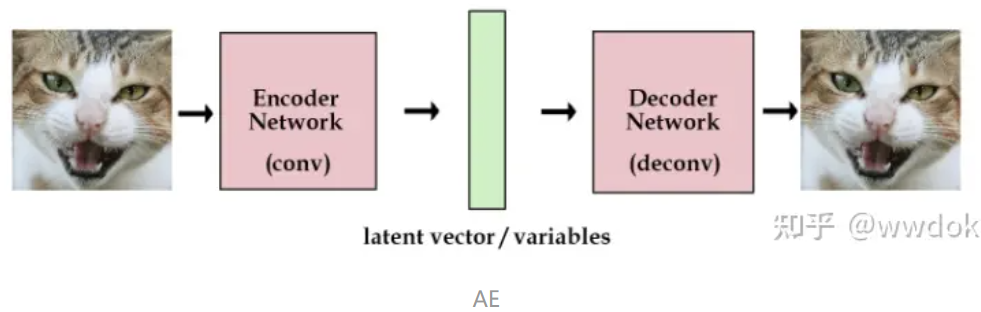
左右两边是端到端的输入输出网络，中间的绿色是提取的特征向量，这是一种直接从图片提取特征并将特征直接重建回去的方式，而VAE（Variational Auto Encoder）长这样：
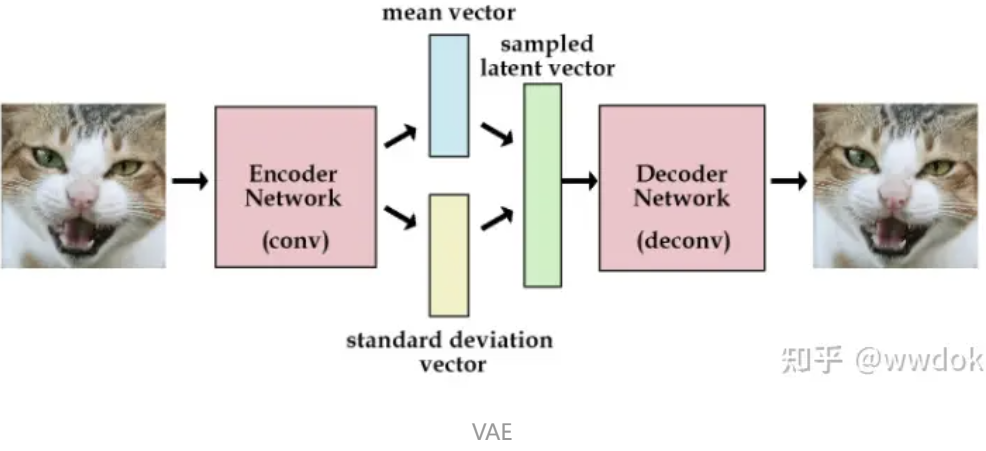

VAE的想法是：
> 不直接用编码器去提取特征向量（也就是隐向量），而是提取这张图像的分布特征，比如说均值和标准差，也就是把绿色的特征向量替换为分布的参数向量。然后需要解码图像的时候，就用编码器输出的分布参数采样得到特征向量样本，用这个样本去重建图像

那为何这么做呢？这和梯度反向传播有关
##### 反向传播
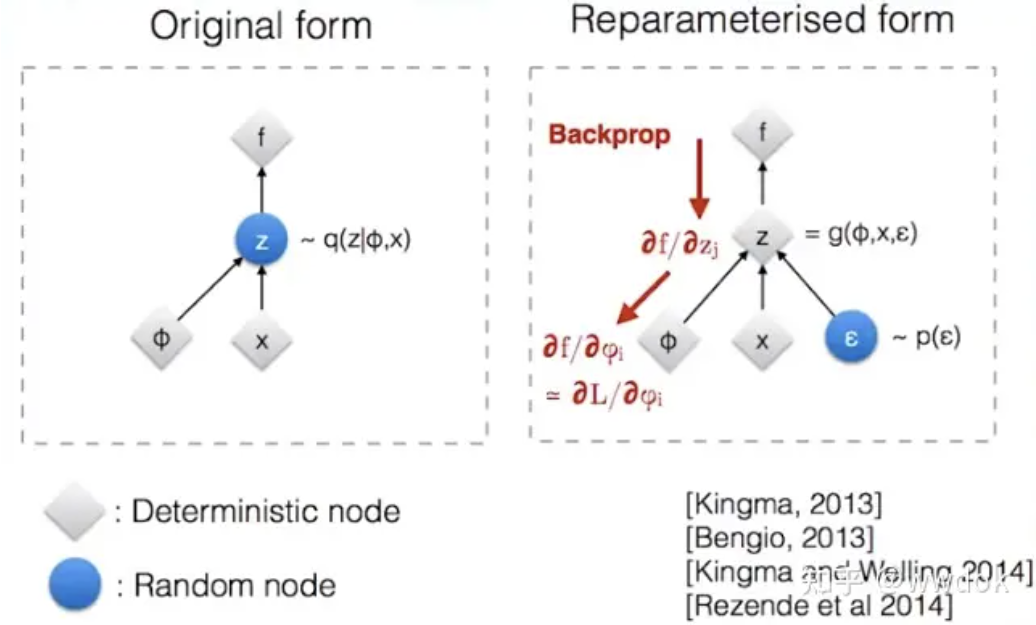
如上，左图直接使用$\phi$和$x$采样，输出的z是随机性的，无法对之前的节点反向传播<br>而右图使用了$z=x+\phi \cdot \epsilon$，把带有随机性的z变成确定性的节点，同时把随机性转嫁给另一个输入节点$\epsilon$————这样一来，采样的过程移出了梯度反向传播的路径，计算图里的参数$\phi$和$x$就可以被反向传播力，而$\epsilon$只是当作一个没有权重变化的输入

用原论文的说法就是：
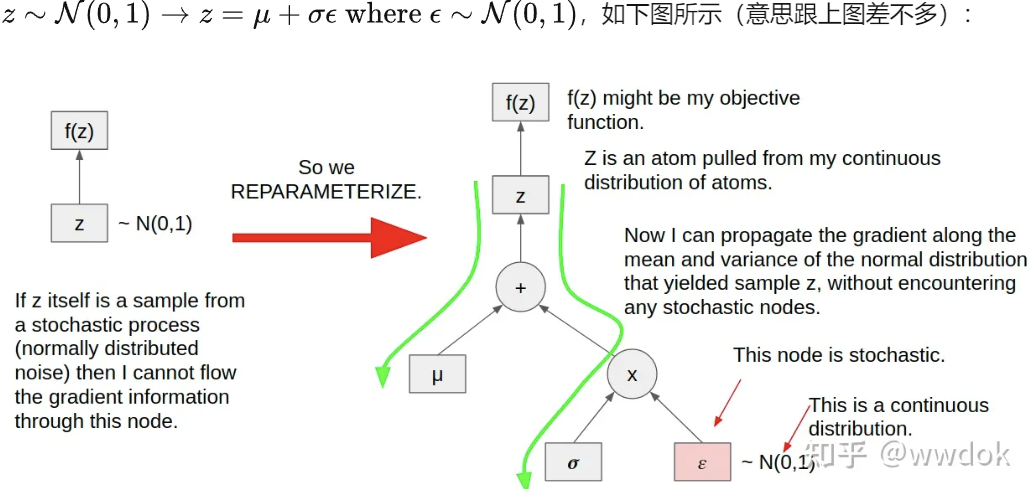

### 3.为何使用Gumbel分布?
> 那为什么随机部分要用gumbel分布而不是常见的高斯分布呢？

文章来源[严格数学证明](https://www.cnblogs.com/initial-h/p/9468974.html)和[简单数学证明](https://zhuanlan.zhihu.com/p/633431594)

> 这是因为gumbel分布是专门用来建模从其他分布，比如高斯分布采样出来的极值形成的分布，而我们这里 **「使用argmax挑出概率最大的那个类别索引Z」** 就属于 **「取极值的操作」**，所以它属于极值分布

在此之前，你可能想都不敢想，极值形成的分布竟然是有规律的，可的确就是有这么神奇的存在，这就是数学的魅力所在，但是要加个条件，就是极值是采样自某一个指数族的概率分布，比如高斯分布。

——但是，这里的Gumbel并非被用于「能求导的argmax」，而是用来模拟「随机采样」的，具体而言，`plot_estimated_probs`函数用于从exanple统计次数并计算概率，则如下两个example几乎是等价的
```python
def sample_gumbel(logits):
    noise = np.random.gumbel(size=len(logits))
    sample = np.argmax(logits+noise)
    return sample
gumbel_samples = [sample_gumbel(logits) for _ in range(n_samples)]
```
以及用np.random.choice方法获取的:
```python
samples = np.random.choice(cats,p=probs,size=n_samples) 
```
显而易见，Gumbel对取最大值进行建模的特性，能够以近似于argmax的方式实现随机采样。

> 注意：这里的logits是对action的prob取对数！！！用如下方法简单证明：
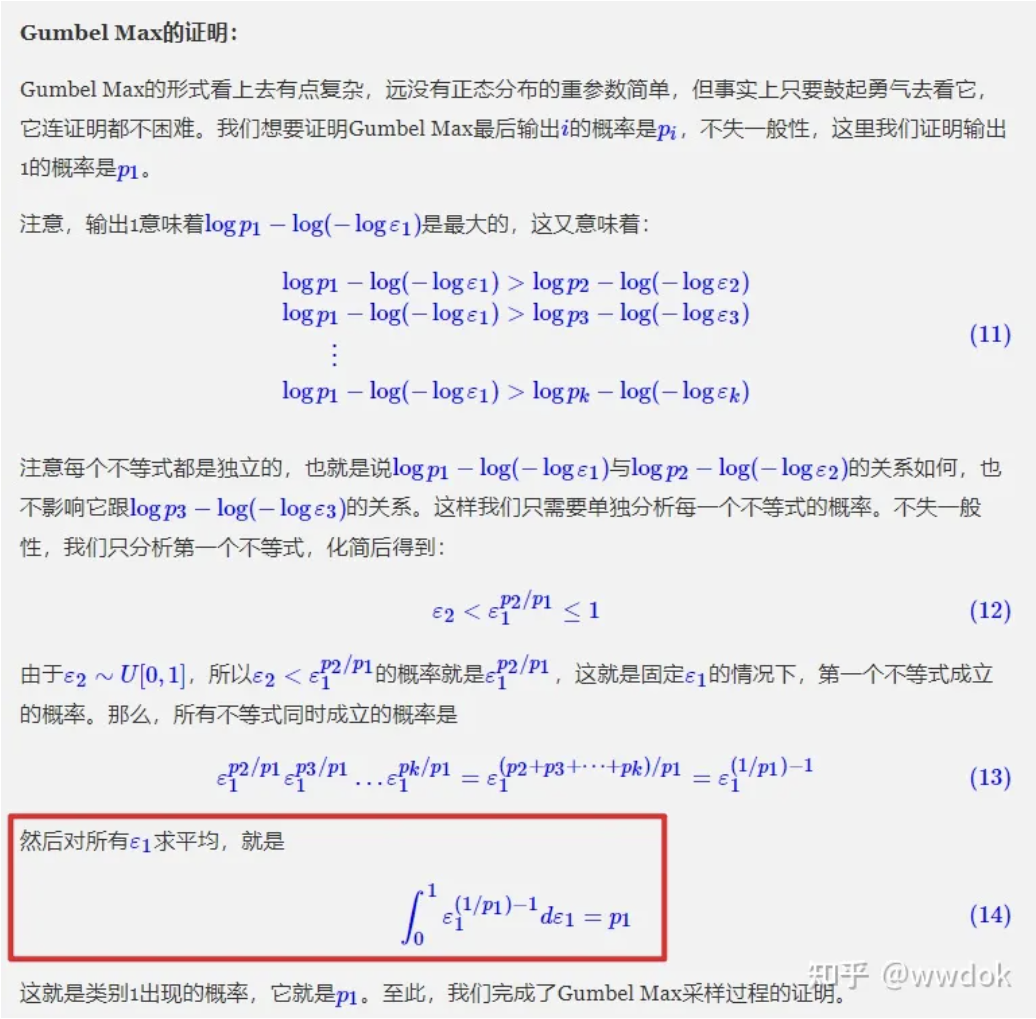



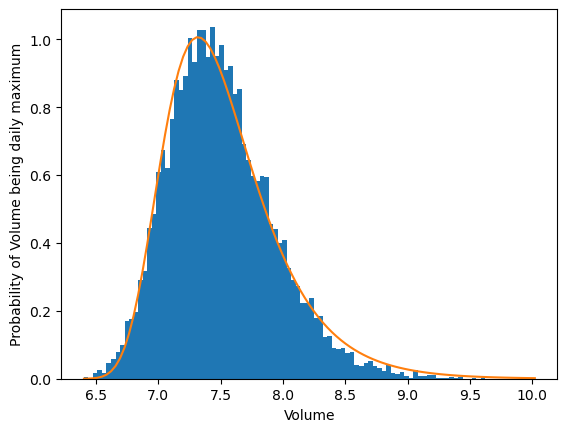

In [9]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
mean_hunger = 5
samples_per_day = 100
n_days = 10000
samples = np.random.normal(loc=mean_hunger, size=(n_days, samples_per_day))
daily_maxes = np.max(samples, axis=1)

def gumbel_pdf(prob,loc,scale):
    z = (prob-loc)/scale
    return np.exp(-z-np.exp(-z))/scale

def plot_maxes(daily_maxes):
    probs,hungers,_=plt.hist(daily_maxes,density=True,bins=100)
    plt.xlabel('Volume')
    plt.ylabel('Probability of Volume being daily maximum')
    (loc,scale),_=curve_fit(gumbel_pdf,hungers[:-1],probs)
    #curve_fit用于曲线拟合
    #接受需要拟合的函数（函数的第一个参数是输入，后面的是要拟合的函数的参数）、输入数据、输出数据
    #返回的是函数需要拟合的参数
    # https://blog.csdn.net/guduruyu/article/details/70313176
    plt.plot(hungers,gumbel_pdf(hungers,loc,scale))
    
plt.figure()
plot_maxes(daily_maxes)


array([0.23214286, 0.23214286, 0.01785714, 0.25      , 0.16071429,
       0.07142857, 0.03571429])

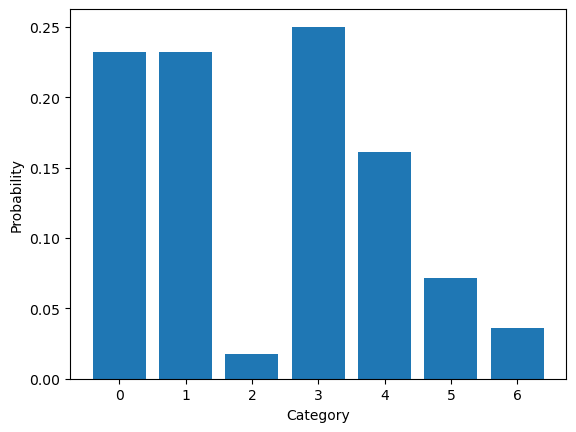

In [11]:
n_cats = 7
cats = np.arange(n_cats)
probs = np.random.randint(low=1, high=20, size=n_cats)
probs = probs / sum(probs)
logits = np.log(probs)
def plot_probs():
    plt.bar(cats, probs)
    plt.xlabel("Category")
    plt.ylabel("Probability")
plt.figure()
plot_probs()
probs

Original probabilities:		0.23  0.23  0.02  0.25  0.16  0.07  0.04
Estimated probabilities:	0.23  0.23  0.02  0.26  0.17  0.07  0.04


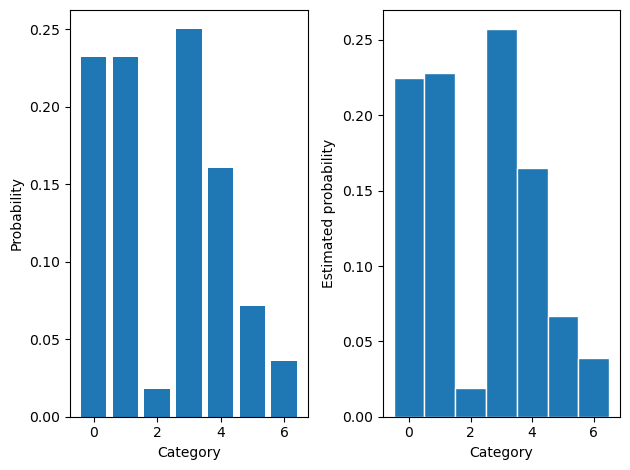

In [12]:
n_samples = 1000
def plot_estimated_probs(samples,ylabel=''):
    n_cats = np.max(samples)+1
    estd_probs,_,_ = plt.hist(samples,bins=np.arange(n_cats+1),align='left',edgecolor='white',density=True)
    plt.xlabel('Category')
    plt.ylabel(ylabel+'Estimated probability')
    return estd_probs
def print_probs(probs):
    format_str = '  '.join(['{:.2f}'] * len(probs))
    print(format_str.format(*probs))

samples = np.random.choice(cats,p=probs,size=n_samples) 

plt.figure()
plt.subplot(1,2,1)
plot_probs()
plt.subplot(1,2,2)
estd_probs = plot_estimated_probs(samples)
plt.tight_layout()#紧凑显示图片

print('Original probabilities:\t\t',end='')
print_probs(probs)
print('Estimated probabilities:\t',end='')
print_probs(estd_probs)


Original probabilities:		0.23  0.23  0.02  0.25  0.16  0.07  0.04
Gumbel Estimated probabilities:	0.25  0.21  0.01  0.24  0.17  0.06  0.04
Normal Estimated probabilities:	0.25  0.27  0.00  0.29  0.16  0.03  0.01
Uniform Estimated probabilities:0.26  0.31  0.00  0.41  0.02


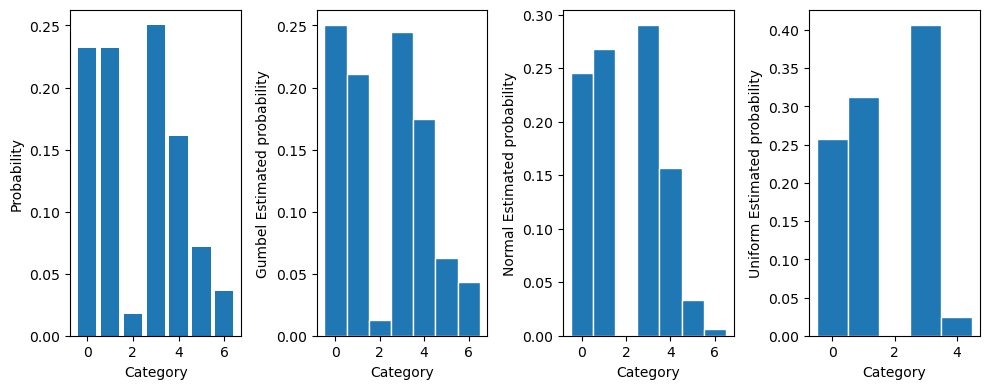

In [13]:
def sample_gumbel(logits):
    noise = np.random.gumbel(size=len(logits))
    sample = np.argmax(logits+noise)
    return sample
gumbel_samples = [sample_gumbel(logits) for _ in range(n_samples)]

def sample_uniform(logits):
    noise = np.random.uniform(size=len(logits))
    sample = np.argmax(logits+noise)
    return sample
uniform_samples = [sample_uniform(logits) for _ in range(n_samples)]

def sample_normal(logits):
    noise = np.random.normal(size=len(logits))
    sample = np.argmax(logits+noise)
    return sample
normal_samples = [sample_normal(logits) for _ in range(n_samples)]

plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plot_probs()
plt.subplot(1,4,2)
gumbel_estd_probs = plot_estimated_probs(gumbel_samples,'Gumbel ')
plt.subplot(1,4,3)
normal_estd_probs = plot_estimated_probs(normal_samples,'Normal ')
plt.subplot(1,4,4)
uniform_estd_probs = plot_estimated_probs(uniform_samples,'Uniform ')
plt.tight_layout()

print('Original probabilities:\t\t',end='')
print_probs(probs)
print('Gumbel Estimated probabilities:\t',end='')
print_probs(gumbel_estd_probs)
print('Normal Estimated probabilities:\t',end='')
print_probs(normal_estd_probs)
print('Uniform Estimated probabilities:',end='')
print_probs(uniform_estd_probs)


## Tensor & numpy试验

In [ ]:
probs = [0.2, 0.5, 0.3]
probs = torch.tensor(np.array(probs),dtype=torch.float)
action_dist = torch.distributions.Categorical(probs)
action = action_dist.sample().item()
action

In [ ]:
probs = torch.tensor([[0.2, 0.8], [0.5, 0.5], [0.7, 0.3]])
actions = torch.tensor([[0],[1],[0]])

In [ ]:
actions = actions.view(-1,1)
actions

In [ ]:
probs.gather(1,actions)

In [ ]:
argmax_acs = (probs == probs.max(1,keepdim=True)[0]).float()
argmax_acs

In [ ]:
action_n = torch.eye(probs.shape[1])
action_n

In [ ]:
action_nv = action_n[[np.random.choice(2,size=probs.shape[0])]]
action_nv

In [ ]:
np.random.choice(2,size=probs.shape[0])

In [ ]:
eps = 0.2
torch.stack([
        argmax_acs[i] if r > eps else action_nv[i]
        for i, r in enumerate(torch.rand(probs.shape[0]))
])

In [ ]:
def gumbel_pdf(x, mu=0, beta=1):
    z = (x - mu) / beta
    return np.exp(-z - np.exp(-z)) / beta

print(gumbel_pdf(0.5, 0.5, 2))

In [ ]:
obs = torch.tensor([[[1,2,3],[3,1,2],[2,1,3]]],dtype=torch.float)
act = torch.tensor([[[0,1,0],[1,0,0],[0,1,0]]],dtype=torch.int64)
x = torch.cat((*obs,*act),dim=1)

In [ ]:
(*obs,*act)

## 环境

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import rl_utils
import sys
sys.path.append("multiagent-particle-envs")
import gym
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios

def make_env(scenario_name):
    # 从环境文件脚本中创建环境
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                        scenario.observation)
    return env

d:\ProgramData\anaconda3\envs\9T_PY307\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## gumbel-softmax

In [2]:
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 生成随机动作,转换成独热形式
    rand_acs = torch.autograd.Variable(torch.eye(logits.shape[1])[[
        np.random.choice(range(logits.shape[1]), size=logits.shape[0])
    ]],
                                       requires_grad=False).to(logits.device)
    # 通过epsilon-贪婪算法来选择用哪个动作，r是
    return torch.stack([
        argmax_acs[i] if r > eps else rand_acs[i]
        for i, r in enumerate(torch.rand(logits.shape[0]))
    ])


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),
                                requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样，加上从sample_gumbel生成的噪声"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y  # * 式（1）
    # * 减一个y再加一个y，仍然是onehot_y，也就是离散的action
    # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
    # 正确地反传梯度
    # * 我的理解是，对于最后return的y来说，是离散的动作（独热的），但是求梯度时，
    # * 在式（1）中，由于前面detach了，没有梯度，因此只对后一个y求梯度，
    # * 这个y是来自上一个函数gumbel_softmax_sample得到的y，这样就可以反向传播了
    return y

## DDPG

In [3]:
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,
                 actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,
                                       hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1,
                                        hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) +
                                    param.data * tau)

## MADDPG

In [4]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
                 state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states, explore):
        states = [
            torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in range(len(env.agents))
        ]
        return [
            agent.take_action(state, explore)
            for agent, state in zip(self.agents, states)
        ]

    def update(self, sample, i_agent):
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)
        ]
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(
            -1, 1) + self.gamma * cur_agent.target_critic(
                target_critic_input) * (1 - done[i_agent].view(-1, 1))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value,
                                            target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()
        #👆针对critic_loss反向传播更新actor

        cur_agent.actor_optimizer.zero_grad()
        #👆清空梯度，准备更新actor网络
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

## 初始化参数

In [5]:
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_interval = 2
minimal_size = 4

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:
    action_dims.append(action_space.n)
for state_space in env.observation_space:
    state_dims.append(state_space.shape[0])
critic_input_dim = sum(state_dims) + sum(action_dims)

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)

## 评估和训练

In [6]:
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)
            rew = np.array(rew)
            returns += rew / n_episode
    return returns.tolist()

In [7]:
return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state = env.reset()
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state

        total_step += 1
        if replay_buffer.size(
        ) >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)

            def stack_array(x):
                rearranged = [[sub_x[i] for sub_x in x]
                              for i in range(len(x[0]))]
                return [
                    torch.FloatTensor(np.vstack(aa)).to(device)
                    for aa in rearranged
                ]
            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(env_id, maddpg, n_episode=100)
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")

d:\ProgramData\anaconda3\envs\9T_PY307\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
d:\1_GitProject\2_ML\3_MAPPDG\rl_utils.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state), action, reward, np.array(next_state), done


Episode: 100, [-45.4011571112847, -1.1149028096552318, -1.1149028096552318]
Episode: 200, [-27.25308816481344, 1.1525260448815418, 1.1525260448815418]
Episode: 300, [-22.90715536657194, -3.2064039175667594, -3.2064039175667594]
Episode: 400, [-20.267781729919097, -3.0590271076775104, -3.0590271076775104]
Episode: 500, [-21.587636039482277, -0.6856168803409881, -0.6856168803409881]
Episode: 600, [-14.546020148182611, -1.3271784271025453, -1.3271784271025453]
Episode: 700, [-15.566782446713082, 4.016690163098367, 4.016690163098367]
Episode: 800, [-14.442536425240352, 4.792513308776104, 4.792513308776104]
Episode: 900, [-16.967291638319683, 6.615462401381467, 6.615462401381467]
Episode: 1000, [-19.101378241572426, 6.331532184923257, 6.331532184923257]
Episode: 1100, [-16.439836058857036, 3.638502468985951, 3.638502468985951]
Episode: 1200, [-17.55510077554784, 6.220355531030467, 6.220355531030467]
Episode: 1300, [-14.81189863196105, 5.528934681934428, 5.528934681934428]
Episode: 1400, [-1

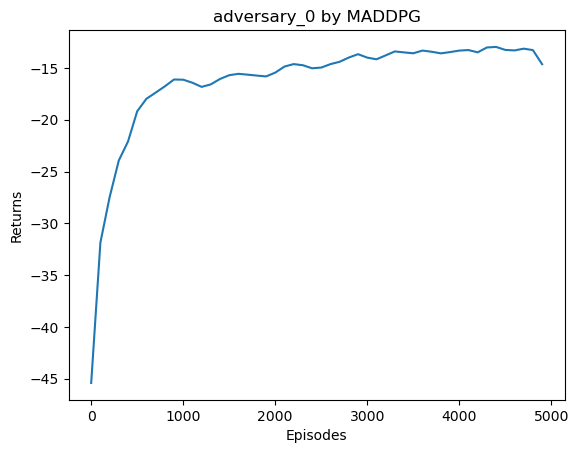

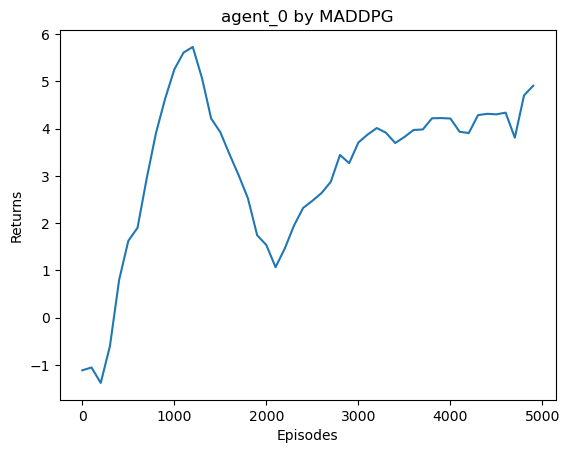

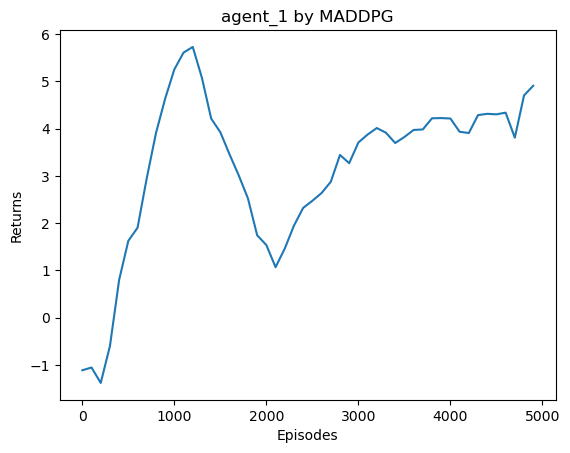

In [8]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(
        np.arange(return_array.shape[0]) * 100,
        rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

In [ ]:
env.close()

# 关于stack_array函数的解释

In [ ]:
import numpy as np
import torch

In [ ]:
def stack_array(x):
    rearranged = [[sub_x[i] for sub_x in x]
                    for i in range(len(x[0]))]
    return [
        torch.FloatTensor(np.vstack(aa))
        for aa in rearranged
    ]

In [ ]:
# 环境给出的状态形式，每行代表某一时刻三个智能体的观测，这里假设是随机抽了三个，即行数
x = [[np.array([1, 2]), np.array([3, 4]), np.array([3, 5])],
     [np.array([4, 2]), np.array([0, 7]), np.array([5, 5])],
     [np.array([1, 5]), np.array([4, 7]), np.array([6, 2])],]


In [ ]:
# 第一步
[[sub_x[i] for sub_x in x] for i in range(len(x[0]))]

# 其实就是转置，但是列表不能转置

In [ ]:
aa = [[sub_x[i] for sub_x in x] for i in range(len(x[0]))][0]

In [ ]:
aa

In [ ]:
np.vstack(aa)

In [ ]:
stack_array(x)  # 把array拆了，倒数第二维变成torch.tensor
# 此时第一个输入的样本，即第一个tensor，就是该批次中，第一个智能体所碰到的全部当前状态
# 第二个tensor，就是第二个智能体碰到的全部当前状态
# 里面tensor部分就和单智能体一样了，参考后面的单智能体输出结果

## 单智能体的输出过程

In [ ]:
replay_buffer.sample(3)

In [ ]:
b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(3)
transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 
                    'rewards': b_r, 'dones': b_d, 'truncated': b_t}

In [ ]:
b_s

In [ ]:
transition_dict['states']

In [ ]:
torch.tensor(transition_dict['states'], dtype=torch.float)